<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Three-Azure-&quot;gotchas&quot;" data-toc-modified-id="Three-Azure-&quot;gotchas&quot;-1">Three Azure "gotchas"</a></span><ul class="toc-item"><li><span><a href="#1.-Accumulation-of-drift" data-toc-modified-id="1.-Accumulation-of-drift-1.1">1. Accumulation of drift</a></span></li><li><span><a href="#2.-The-Azure-clock-starts-at-200-ms-when-it-receives-the-first-trigger-and-it's-in-subordinate-mode" data-toc-modified-id="2.-The-Azure-clock-starts-at-200-ms-when-it-receives-the-first-trigger-and-it's-in-subordinate-mode-1.2">2. The Azure clock starts at 200 ms when it receives the first trigger and it's in subordinate mode</a></span></li><li><span><a href="#3.-The-Azure-depth-frames-start-before-the-syncing-pulse-arrives" data-toc-modified-id="3.-The-Azure-depth-frames-start-before-the-syncing-pulse-arrives-1.3">3. The Azure depth frames start before the syncing pulse arrives</a></span></li></ul></li><li><span><a href="#Azure-ts-inspection" data-toc-modified-id="Azure-ts-inspection-2">Azure ts inspection</a></span></li><li><span><a href="#Validating-the-syncing-method" data-toc-modified-id="Validating-the-syncing-method-3">Validating the syncing method</a></span><ul class="toc-item"><li><span><a href="#Load-the-trigger-signal-recorded-on-the-Teensy" data-toc-modified-id="Load-the-trigger-signal-recorded-on-the-Teensy-3.1">Load the trigger signal recorded on the Teensy</a></span></li><li><span><a href="#Load-the-pre-processed-sync-via-the-LED-method" data-toc-modified-id="Load-the-pre-processed-sync-via-the-LED-method-3.2">Load the pre-processed sync via the LED method</a></span></li><li><span><a href="#Compare-with-the-triggers" data-toc-modified-id="Compare-with-the-triggers-3.3">Compare with the triggers</a></span></li><li><span><a href="#[DEPRECATED]-Do-the-syncing" data-toc-modified-id="[DEPRECATED]-Do-the-syncing-3.4">[DEPRECATED] Do the syncing</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from top_bottom_moseq.util import count_frames, match_frames
import os
from os.path import join
import moseq_fo.util.timeseries_utils as tsu
import moseq_fo.util.np_utils as npu
import av
import pandas as pd
import warnings

In [2]:
def count_frames(file_name):
    with av.open(file_name, 'r') as reader:
        return reader.streams.video[0].frames    
    

def index_of_nearest_value(data_timestamps, event_timestamps, side='both'):
    """
    https://github.com/AllenInstitute/mindscope_utilities/blob/e5aa1e6aebf3f62570aaff0e2e9dba835c999a23/mindscope_utilities/general_utilities.py#L149
    The index of the nearest sample time for each event time.
    Parameters:
    -----------
    sample_timestamps : np.ndarray of floats
        sorted 1-d vector of data sample timestamps.
    event_timestamps : np.ndarray of floats
        1-d vector of event timestamps.
    boundary_tol: float (default: None)
        If None, excludes event timestamps that are outside of the data timestamps range
        If a float, values within edge_tol of the first/last times are allowed.
    side: str (default "both")
        If "previous", returns index of closest data timestamp BEFORE each event 
        If "subsequent", returns index of closest data timestamp AFTER each event 
        If "both", returns absolute closest data timestamp for each event
    Returns:
    --------
    event_aligned_ind : np.ndarray of int
        An array of nearest sample time index for each event times.
        Event times outside of the bounds are given an index of -1.
        (NB, of course -1 is still a valid index in Python! But there is no integer nan, so -1 is the best way we have to say "invalid intger")
    """
    data_timestamps, event_timestamps = npu.castnp(data_timestamps, event_timestamps)

    insertion_ind = np.searchsorted(data_timestamps, event_timestamps, side='left')

    # Sanitize event timestamps outside of the data timestamps range
    outside_range_bool = np.logical_or(
        event_timestamps < data_timestamps[0], event_timestamps > data_timestamps[-1]
    )
    if outside_range_bool.sum() > 0:
        warnings.warn(
            "Some event timestamps are outside the range of data timestamps. Such indices will be denoted -1 in the returned vector."
        )
    insertion_ind = insertion_ind[~outside_range_bool]

    if side=='both':
        # Is the value closer to data at insertion_ind or insertion_ind-1?
        ind_diff = data_timestamps[insertion_ind] - event_timestamps[~outside_range_bool]
        ind_minus_one_diff = np.abs(
            data_timestamps[np.clip(insertion_ind - 1, 0, np.inf).astype(int)]
            - event_timestamps[~outside_range_bool]
        )
        event_indices = insertion_ind - (ind_diff > ind_minus_one_diff).astype(int)
    elif side=='previous':
        event_indices = insertion_ind - 1
    elif side=='subsequent':
        event_indices = insertion_ind

    # Pad with nans in case some values were removed due to boundaries
    event_indices_full = -1 * np.ones(event_timestamps.shape, dtype="int")
    event_indices_full[~outside_range_bool] = event_indices

    return event_indices_full

In [3]:
%matplotlib inline

In [5]:
# path = '/n/groups/datta/Jonah/top_bottom_trigger_testing/trigger_test/'
# prefix = '20230308_trigger_test'  # good

# path = '/n/groups/datta/Jonah/top_bottom_trigger_testing/trigger_test/'
# prefix = '20230428_long_test'

path = '/n/groups/datta/Jonah/top_bottom_trigger_testing/trigger_test/'
# prefix = '20230502_long_test'
# prefix = '20230502_offset_test_wait'
prefix = '20230502_full_test'

# Three Azure "gotchas"

In [6]:
# Load the timestamps
top_ts_tmp = np.load(join(path, prefix, prefix+'.top.device_timestamps.npy'))

In [7]:
top_ts_tmp[:5]/1e6

array([0.240533, 0.266766, 0.299988, 0.333333, 0.366666])

## 1. Accumulation of drift
If you look at the device timestamps for the frames, it looks like everything is roughly correct -- 33,333 usec per frame.

In [8]:
np.unique(np.diff(top_ts_tmp))

array([26233, 33211, 33222, 33223, 33233, 33234, 33244, 33245, 33322,
       33333, 33334, 33344, 33345, 33422, 33433, 33434, 33444, 33445,
       33455, 33456])

You might then naively calculate trigger number based on the number of 33,333 usec periods that have elapsed. This makes it look like there are some dropped frames and some odd double-frames in the middle of the recording. Is that right?

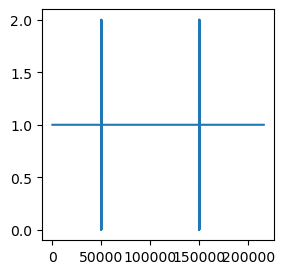

In [9]:
diffs = np.diff(np.rint(top_ts_tmp/33333))
plt.figure(figsize=(3,3))
plt.plot(diffs)

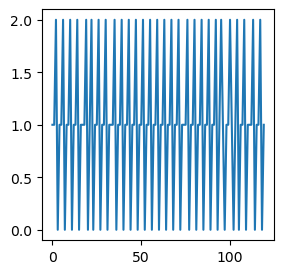

In [10]:
# zoom in
s = slice(49900, 50020)
plt.figure(figsize=(3,3))
plt.plot(diffs[s])

It turns out this is an artefact of the drifting timestamps + rounding issues. For example, if `(timestamps / fr period)` were `[7.499, 8.501, 9.501, 10.499]` you would round to `[7 9 9 10]`, and your diffs would jump between 0 and 2, as like in the above plot.

Indeed, when we look at how the inter-frame intervals add up over time, we can see the drift is equal to about 1 frame per hour.

In [11]:
rec_length_in_hrs = (top_ts_tmp[-1] - top_ts_tmp[0])/1e6/60/60
ratio_of_inter_frame_intervals_to_expected = np.diff(top_ts_tmp)/33333  # should be ~1, and it is -- but slightly skewed positive
total_difference = np.sum(ratio_of_inter_frame_intervals_to_expected - 1)
total_difference/rec_length_in_hrs  # frames per hour of drift

0.9732477139661457

The proper solution is to count frames by taking the inter-frame interval first, rounding to the nearest number of 33,333 usec periods, and adding those. This reveals no dropped frames.

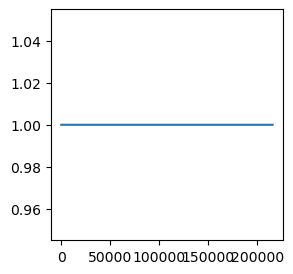

In [12]:
diffs = np.rint(np.diff(top_ts_tmp)/33333)
plt.figure(figsize=(3,3))
plt.plot(diffs)

## 2. The Azure clock starts at 200 ms when it receives the first trigger and it's in subordinate mode
As bizarre as this sounds, [it's true](https://github.com/microsoft/Azure-Kinect-Sensor-SDK/issues/1240#issuecomment-657889663). On top of this, the Python script that we use often drops the first frame or two. So, in order to match everything up, you need to do something like this:

In [13]:
azure_sync_start_offset = 200000  # 200 ms
frame_length = 33333
n_initial_dropped_frames = np.rint((top_ts_tmp[0] - azure_sync_start_offset)/frame_length).astype('int')
trigger_num_by_frame = n_initial_dropped_frames + np.hstack([0, np.cumsum(np.rint(np.diff(top_ts_tmp)/frame_length).astype(int))])
trigger_num_by_frame

array([     1,      2,      3, ..., 215821, 215822, 215823])

In [14]:
n_initial_dropped_frames

1

Note that this logic with `np.cumsum` catches dropped frames:

In [15]:
dropped_fr_ts = np.array([0, 10, 20, 40, 50]) 
np.cumsum(np.rint(np.diff(dropped_fr_ts)/10).astype(int))

array([1, 2, 4, 5])

## 3. The Azure depth frames start before the syncing pulse arrives
This one is the most fun yet. 

(NB: this won't actually matter most of the time, but it's worth knowing)

As discussed [here](https://github.com/microsoft/Azure-Kinect-Sensor-SDK/issues/868#issuecomment-594120342) and in wes-b's subsequent reply, it's the Azure's **color** camera which is aligned to syncing pulses. How does this relate to the depth/IR frames?

"The delay between color and depth start is (color exposure)/2 - (depth exposure)/2. In the case where the depth exposure is larger than color expose the same formula is used. The result is negative and therefore requires the depth capture to start before color." 

In our code, we turn the color camera off entirely (I think), because we don't want to deal with any more data than we need to. And the depth / IR "exposure time" is practically 12 ms (it's more complicated but we can gloss over that for now). So the Azure times itself such that the depth frames are actually started `(0/2-12/2)` = **~6 ms before** the syncing signal arrives.


Based on some testing (see `azure_ir_offset_from_trigger` variable below), I think that the IR frame is collected at the end of the depth frame, ie **6 ms _after_** the trigger. By adding a trigger offset condition into the condition for changing the sync LEDs, I'm able to have this be a non-issue for the sync validation. But if anyone ever needs to use the IR frames from the triggered Azure, it's good to know that they're 6 ms behind the trigger. 

# Azure ts inspection

In [16]:
az_diffs = np.diff(top_ts_tmp)

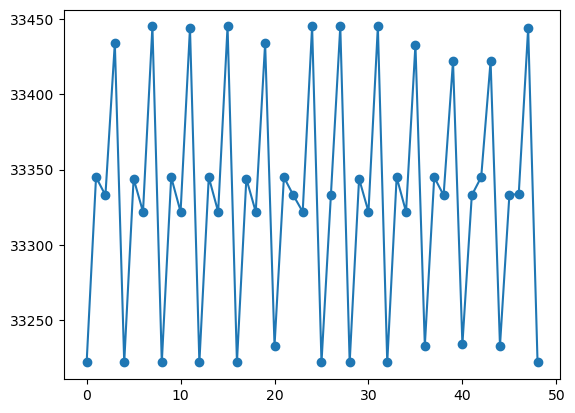

In [17]:
plt.plot(az_diffs[1:50], '-o')

# Validating the syncing method

Up until now, we flashed LEDs in semi-random patterns to encode an integer into each frame, and then we used that integer to align with our other data streams. Here I use that to independently validate the trigger syncing. I recorded the trigger signal + the LED signals on a Teensy.

## Load the trigger signal recorded on the Teensy

In [18]:
ino_df = pd.read_csv(join(path, prefix, prefix +'.txt'))
trigger_col_name = 'trigger'
frame_period_in_msec = 33.333

# If arduino trigger count does not start at zero, alignment will be ambiguous!
assert ino_df.loc[0, trigger_col_name] == 0

In [19]:
ino_df.head()

,time,led1,led2,led3,led4,yaw,roll,pitch,acc_x,acc_y,acc_z,therm,dac,trigger
0,34244,0,0,0,0,11.875,-75.125,-59.8125,0.08,-0.05,0.0,0,3.3,0
1,34247,0,0,0,0,11.875,-75.125,-59.8125,0.08,-0.05,0.0,0,3.3,0
2,34249,0,0,0,0,11.875,-75.125,-59.8125,0.08,-0.05,0.0,0,3.3,0
3,34251,0,0,0,0,11.875,-75.125,-59.8125,0.08,-0.05,0.0,0,3.3,0
4,34253,0,0,0,0,11.875,-75.125,-59.8125,0.08,-0.05,0.0,0,3.3,0


[0 1 2 3 4 5 6 7 8 9]


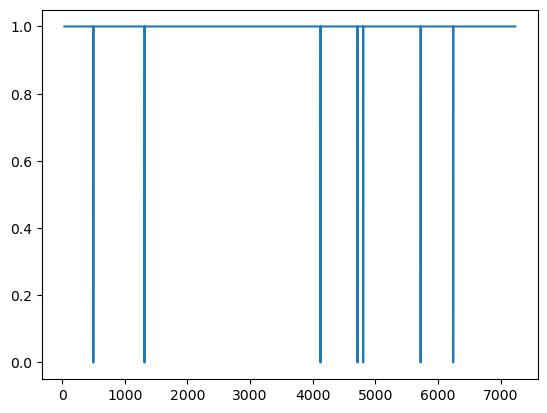

In [20]:
# Find lines where the trigger interrupt was incremented
diffs = np.hstack([np.nan, np.diff(ino_df[trigger_col_name])])
ino_trigger_idx = np.where(diffs>=1)[0]
ino_trigger_times = ino_df.time[ino_trigger_idx].reset_index(drop=True)

# There's no guarantee that the Teensy didn't miss any triggers,
# so we need to use the same trick we used with the Azure
# and convert trigger times into n triggers.
ino_trigger_nums = np.hstack([0, np.cumsum(np.rint(np.diff(ino_trigger_times)/frame_period_in_msec).astype(int))])
print(ino_trigger_nums[:10])

plt.plot(ino_trigger_times[1:]/1000, np.diff(ino_trigger_nums))  # looks like none dropped

In [21]:
# debug: sometimes there are diffs of 0, without a corresponding diff of 2? 
# So is teensy actually receiving two triggers, or is it mis-counting due to some kind of phantom hardware signal?
# After some googling -- people have seen this behavior before. Probably phantom.
# See: https://forum.pjrc.com/threads/68738-T4-1-phantom-digital-interrupts-firing-(Scope-video-incl)?s=cb047d50e765fc222a37ab81628597f1&p=294571#post294571
# And see: https://forum.pjrc.com/threads/68349-T4-1-multiple-interrupts-firing-on-one-pin-state-change

# diff_zero_idx = ino_trigger_idx[np.where(np.diff(ino_trigger_nums)==0)[0]]
# ii = diff_zero_idx[0]
# ino_df.loc[(ii-10):(ii+10), :]

In [22]:
# np.unique(np.diff(ino_trigger_times))

## Load the pre-processed sync via the LED method
NB, you need to use the flag `--exclude-off-only` in the moseq2_ephys_sync pipeline to avoid off-by-one errors at events where LEDs only turned off (i.e. none turned on), because sometimes LEDs are one frame slow to turn off (capacitance? some kind of hardware issue).

In [26]:
import moseq2_ephys_sync as mes
import pdb

In [27]:
led_events = np.load(join(path, prefix, 'sync/top_ir_avi_led_events.npy'))
led_events

array([[ 1.40000000e+00,  3.00000000e+00, -1.00000000e+00,
         3.50000000e+01],
       [ 1.40000000e+00,  2.00000000e+00,  1.00000000e+00,
         3.50000000e+01],
       [ 1.40000000e+00,  1.00000000e+00,  1.00000000e+00,
         3.50000000e+01],
       ...,
       [ 7.19146666e+03,  2.00000000e+00, -1.00000000e+00,
         2.15737000e+05],
       [ 7.19146666e+03,  1.00000000e+00,  1.00000000e+00,
         2.15737000e+05],
       [ 7.19146666e+03,  3.00000000e+00, -1.00000000e+00,
         2.15737000e+05]])

In [28]:
codes = np.load(join(path, prefix, 'sync/codes_top_ir_avi_and_txt.npz'))
c1, c2 = codes['first_source_codes'], codes['second_source_codes']  # time, code, offset, idx


In [29]:
matches = np.load(join(path, prefix, 'sync/matches.npy'))
tmp = np.load(join(path, prefix, 'sync/top_ir_avi_from_txt_residuals.npz'))
ts, resids = tmp['timestamps'], tmp['residuals']
matches
# matches[:,0] = az times
# matches[:,1] = ino times
# matches[:,2] = az indices
# matches[:,3] = ino indices

array([[1.40000000e+00, 3.43640000e+01, 3.50000000e+01, 5.80000000e+01],
       [6.40010000e+00, 4.05400000e+01, 1.85000000e+02, 3.04800000e+03],
       [1.14001000e+01, 4.55390000e+01, 3.35000000e+02, 5.46700000e+03],
       ...,
       [7.12646666e+03, 7.16054500e+03, 2.13787000e+05, 3.43894000e+06],
       [7.13146666e+03, 7.16554600e+03, 2.13937000e+05, 3.44135100e+06],
       [7.13646677e+03, 7.17054700e+03, 2.14087000e+05, 3.44377300e+06]])

In [30]:
matches[:10, :]

array([[1.4000000e+00, 3.4364000e+01, 3.5000000e+01, 5.8000000e+01],
       [6.4001000e+00, 4.0540000e+01, 1.8500000e+02, 3.0480000e+03],
       [1.1400100e+01, 4.5539000e+01, 3.3500000e+02, 5.4670000e+03],
       [1.6399988e+01, 5.0540000e+01, 4.8500000e+02, 7.8850000e+03],
       [2.1400100e+01, 5.5540000e+01, 6.3500000e+02, 1.0297000e+04],
       [2.6399988e+01, 6.0540000e+01, 7.8500000e+02, 1.2725000e+04],
       [3.6399988e+01, 7.0540000e+01, 1.0850000e+03, 1.7568000e+04],
       [4.6399988e+01, 8.0539000e+01, 1.3850000e+03, 2.2391000e+04],
       [5.6399988e+01, 9.0539000e+01, 1.6850000e+03, 2.7211000e+04],
       [6.6399988e+01, 1.0053900e+02, 1.9850000e+03, 3.2031000e+04]])

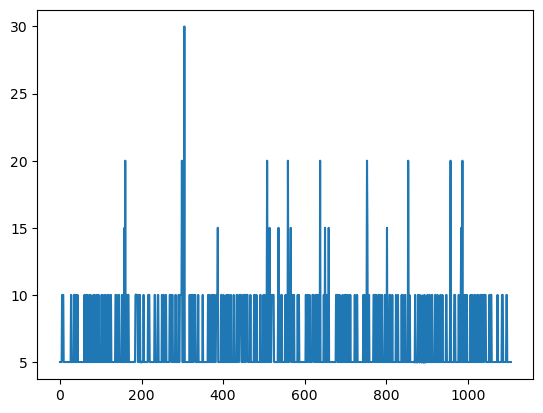

In [31]:
plt.plot(np.diff(matches[:,0]))  # won't be all 5's since we're exlcuding only-off events

## Compare with the triggers

Now in order to compare this with the triggers, we do the following procedure:


for a given LED match event (i.e. the frame in the Azure movie where the LEDs changed, and the row in the Teensy record where the LEDs changed)
1) find the nearest trigger in the Teensy record
2) Use the trigger values to find the corresponding Azure frame, 
3) Compare that frame to the frame we expected based on the LED match event.

In [32]:
# azure_ir_offset_from_trigger = 0.0064  # account for delay betw when trigger arrives vs when IR frame is actually captured
azure_ir_offset_from_trigger = 0

In [33]:
# pick a random LED match event
random_idx = 0

# info for this LED match event
ino_ts = matches[random_idx, 1]
az_ts = matches[random_idx, 0]
az_fr = int(matches[random_idx, 2])
print(f'Expect az fr num: {az_fr} (ts: {az_ts})')

# find the closest trigger in the list of teensy trigger times
ino_closest_subsequent_trigger_idx = index_of_nearest_value(
    (ino_trigger_times/1000) + azure_ir_offset_from_trigger, # convert to sec
    ino_ts, 
    side='subsequent',  # critically, need to use the following trigger, since Azure won't know about the LED change on the prev frame, even if it's technically closer
)[0]
ino_closest_abs_trigger_num = ino_trigger_nums[ino_closest_subsequent_trigger_idx]  # convert to absolute trigger number
print(f'Closest absolute trig val from teensy: {ino_closest_abs_trigger_num}')

# find the corresponding azure frame number
az_converted_fr = np.where(trigger_num_by_frame == ino_closest_abs_trigger_num)[0]
az_converted_ts = top_ts_tmp[az_converted_fr]/1e6
print(f'Converted az fr num: {az_converted_fr} (ts: {az_converted_ts})')
print(az_converted_ts - az_ts)



Expect az fr num: 35 (ts: 1.4)
Closest absolute trig val from teensy: 1
Converted az fr num: [0] (ts: [0.240533])
[-1.159467]


Text(0.5, 1.0, 'LED-based validation of azure triggers')

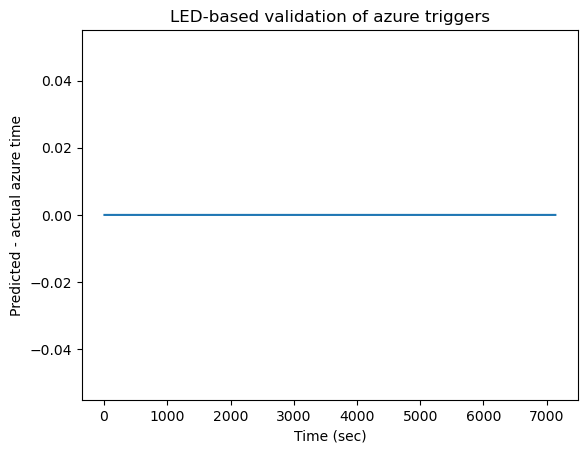

In [41]:
# vectorize it
# azure_ir_offset_from_trigger = 0.0064
azure_ir_offset_from_trigger = 0  # fixed arduino to always change leds far enough away from trigger that this doesn't matter

# All matched timestamps
# ino_ts = matches[:,1]
# az_ts = matches[:,0]
ino_ts = matches[1:,1]  # sth weird with the very first LED match sometimes; the rest look fine.
az_ts = matches[1:,0]

# Find closest trigger following each arduino led event
ino_closest_subsequent_trigger_idx = index_of_nearest_value(
    ino_trigger_times/1000 + azure_ir_offset_from_trigger,
    ino_ts, 
    side='subsequent'
)

# Convert this to absolute trigger number
ino_closest_abs_trigger_nums = ino_trigger_nums[ino_closest_subsequent_trigger_idx]

# Convert absolute trigger number back into azure frame number / ts
az_converted_frs = np.array([np.where((trigger_num_by_frame) == abs_trig_num)[0][0] for abs_trig_num in ino_closest_abs_trigger_nums])
az_converted_ts = top_ts_tmp[az_converted_frs]/1e6

az_diffs = az_converted_ts - az_ts
# plt.plot(np.arange(len(az_converted_ts)), diffs)
# plt.xlabel('LED evt num')
plt.plot(az_converted_ts, az_diffs)
plt.xlabel('Time (sec)')
plt.ylabel('Predicted - actual azure time')
plt.title('LED-based validation of azure triggers')


In [39]:
np.unique(az_diffs)

array([0.])

(array([356., 181., 103.,  42.,  52., 132.,  93.,  93.,  44.,  11.]),
 array([-0.026 , -0.0236, -0.0212, -0.0188, -0.0164, -0.014 , -0.0116,
        -0.0092, -0.0068, -0.0044, -0.002 ]),
 <BarContainer object of 10 artists>)

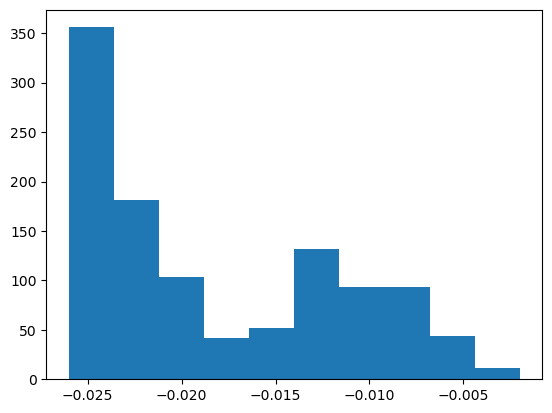

In [43]:
tmp_diffs = matches[1:,1] - ino_trigger_times[ino_closest_subsequent_trigger_idx]/1000
plt.hist(tmp_diffs)  # all neg means leds are switching just before triggers, which is good

## [DEPRECATED] Do the syncing

This is actually unecessary. 

In [ ]:

# def match_azure_frames(azure_timestamps, frame_length=33333, correction=True):
#     # input: timestamps is a list of N arrays, where each array contains the device timestamps from a synced camera
#     # return: n x N array of frame indexes for each camera. Only frames captured by all N cameras are included

#     # timestamps are in microseconds and should all be (approximate) multiple of 33333 + a fixed offset thats <2ms
#     # 1) convert timestamps to integers representing the number of 33333us clock periods
#     # 2) create a table where entry (i,j) if the frame number for camera j at clock period i (or -1 if there is no frame)
#     # 3) return indexes corresponding to mask rows where (i,j) != -1 for all cameras j

#     if correction:
#         offset = np.rint(ts[0]/frame_length).astype('int')
#         azure_timestamps_nframes = [offset + np.hstack([0, np.cumsum(np.rint(np.diff(ts)/frame_length).astype(int))]) for ts in azure_timestamps]
#     else:
#         azure_timestamps_nframes = [np.rint(ts/frame_length).astype(int) for ts in azure_timestamps]
#     assert all([len(ts1) == len(ts2) for (ts1, ts2) in zip(azure_timestamps, azure_timestamps_nframes)])
#     mask = np.ones((np.max(np.hstack(azure_timestamps_nframes))+1,len(azure_timestamps_nframes)))*(-1)
#     for j,ts in enumerate(azure_timestamps_nframes): mask[ts,j] = np.arange(len(ts))
#     return mask[np.all(mask > -1, axis=1),:].astype(int)




# def match_azure_frames_to_trigger_counts(
#     top_azure_timestamps, 
#     ino_trigger_timestamps, 
#     frame_length=33333, 
#     correction=True
# ):
#     """
#     azure_timestamps: list of top device ts, in usec
#     trigger_counts: the trigger column of the arduino data, in msec (doesnt need to be zeroed)
    
#     Returns: (n matched fr) x (2) array, with matched indices into az + ino ts respectively.
#     """
    
#     top_azure_timestamps, ino_trigger_timestamps = npu.castnp(top_azure_timestamps, ino_trigger_timestamps)
    
#     # Azure starts at t=0 roughly when it receives first trigger.
#     # First frame may not be until 7th or 8th trigger, hence find offset.
#     # (even though in general doing rint(ts/fr_length) is wrong due to drift, it should be ok for the first few frames!)
#     if correction:
#         azure_sync_start_offset = 200000  # 200 ms
#         offset = np.rint((top_azure_timestamps[0] - azure_sync_start_offset)/frame_length).astype('int')
#         azure_timestamps_nframes = offset + np.hstack([0, np.cumsum(np.rint(np.diff(top_azure_timestamps)/frame_length).astype(int))])
#     else:
#         azure_timestamps_nframes = np.rint(top_azure_timestamps/frame_length).astype(int)
#     assert len(azure_timestamps_nframes) == len(top_azure_timestamps)
    
    
#     # Adjust ino trigger timestamps so they count frame nums from first trigger
#     ino_trigger_timestamps = ino_trigger_timestamps - ino_trigger_timestamps[0]
#     if correction:
#         offset = np.rint(ino_trigger_timestamps[0]/frame_length).astype('int')
#         ino_trigger_timestamps_nframes = offset + np.hstack([0, np.cumsum(np.rint(np.diff(ino_trigger_timestamps)/(frame_length/1000)).astype(int))])
#     else:
#         ino_trigger_timestamps_nframes = np.rint(ino_trigger_timestamps/(frame_length/1000)).astype(int)
#     assert len(ino_trigger_timestamps_nframes) == len(ino_trigger_timestamps)
    
#     ls = [azure_timestamps_nframes, ino_trigger_timestamps_nframes]
#     mask = -1 * np.ones((np.max(np.hstack(ls)) + 1, len(ls)))
#     for j,ts in enumerate(ls): mask[ts,j] = np.arange(len(ts))
#     return mask[np.all(mask > -1, axis=1),:].astype(int)

In [23]:
# # Do the syncing!!
# matched_trigger_indices = match_azure_frames_to_trigger_counts(
#     top_ts_tmp,
#     ino_trigger_times
# )
# matched_trigger_indices  # col 0 is az, col 1 is teensy

In [24]:
# azure_matched_trig_nums = trigger_num_by_frame[matched_trigger_indices[:,0]]
# ino_matched_trig_nums = ino_trigger_nums[matched_trigger_indices[:,1]]
# assert np.all(azure_matched_trig_nums == ino_matched_trig_nums)

In [25]:
# np.all(azure_matched_trig_nums == ino_matched_trig_nums)